In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import os


In [2]:
# !pip list |grep tensorflow

# Data Loading & Preparation:

In [3]:

def check_data_continuity(data_set):
    for i in range(1, len(data_set)):
        assert data_set.index[i] > data_set.index[i-1]


In [4]:
# 1. Data Loading and Preparation
# file_path = "./data/DWH/features_1min_csv/part-00000-4ea0308d-2f5d-4f28-b0bc-120dad4b7116-c000.csv"
file_path = "./data/DWH/new_features_1min_csv/part-00000-011801cc-ded0-4036-b0f4-aeef100934dd-c000.csv"
df = pd.read_csv(file_path, index_col="t_trade_epoch")

# 2. Feature Selection - in Feature_Selection notebook
features = ['m_stddev_snp_media_events_count_last_15min', 'm_sum_snp_media_events_count_last_60days', 'm_sum_snp_media_events_count_last_30min', 'm_max_snp_media_events_count_last_3days', 'p_min_low_price_for_last_10min', 'p_avg_low_price_for_last_5min', 'm_max_snp_media_events_count_last_15min', 'm_avg_snp_media_events_count_last_60days', 'm_sum_snp_media_events_count_last_7days', 'm_sum_snp_media_events_count_last_3hour', 't_trade_part_open_h', 'm_avg_snp_media_events_count_last_45min', 'm_sum_snp_media_events_count_last_1hour', 'p_min_high_price_for_last_10min', 'p_stddev_volume_price_for_last_10min', 'm_stddev_snp_media_events_count_last_30min', 't_time_diff_between_trade_and_trade_part_open_in_sec', 'p_min_low_price_for_last_3min', 'p_avg_low_price_for_last_10min', 'm_avg_snp_media_events_count_last_15min', 'm_max_snp_media_events_count_last_7days', 'open', 't_trade_part_open_e', 'm_stddev_snp_media_events_count_last_60days', 'p_min_low_price_for_last_5min', 'm_avg_snp_media_events_count_last_7days', 'm_stddev_snp_media_events_count_last_3hour', 'm_stddev_snp_media_events_count_last_14days', 'm_avg_snp_media_events_count_last_3hour', 'high', 'm_avg_snp_media_events_count_last_14days', 't_trade_close_e', 'p_max_volume_price_for_last_10min', 'm_stddev_snp_media_events_count_last_3days', 'p_min_open_price_for_last_10min', 'm_max_snp_media_events_count_last_14days', 'm_sum_snp_media_events_count_last_3days', 'm_max_snp_media_events_count_last_3hour', 'low', 'm_sum_snp_media_events_count_last_15min', 'm_sum_snp_media_events_count_last_14days', 't_trade_hour', 'p_min_close_price_for_last_10min', 'm_avg_snp_media_events_count_last_3days', 'm_avg_snp_media_events_count_last_30min', 't_trade_open_e', 'm_stddev_snp_media_events_count_last_1hour', 'm_stddev_snp_media_events_count_last_45min', 'm_sum_snp_media_events_count_last_30days', 't_precent_of_time_from_start_of_trade_pase', 'm_max_snp_media_events_count_last_30days', 'm_max_snp_media_events_count_last_30min', 't_time_diff_between_trade_and_open_in_sec', 'p_min_close_price_for_last_5min', 't_trade_part', 'm_max_snp_media_events_count_last_1hour', 'm_max_snp_media_events_count_last_45min', 'm_stddev_snp_media_events_count_last_7days', 't_precent_of_time_from_start_of_trade_day', 't_trade_day_of_week', 'p_min_open_price_for_last_5min', 'm_avg_snp_media_events_count_last_1hour', 'm_sum_snp_media_events_count_last_45min', 't_trade_minute', 'm_avg_snp_media_events_count_last_30days', 'm_max_snp_media_events_count_last_60days', 'p_avg_low_price_for_last_3min', 'm_stddev_snp_media_events_count_last_30days']
target = 'close'

# Use chosen features + target, drop rows with any NaN
data = df[features + [target]].dropna()
print(f"rows with any NaN drop - {df.shape[0] - data.shape[0]}")

check_data_continuity(data)


rows with any NaN drop - 0


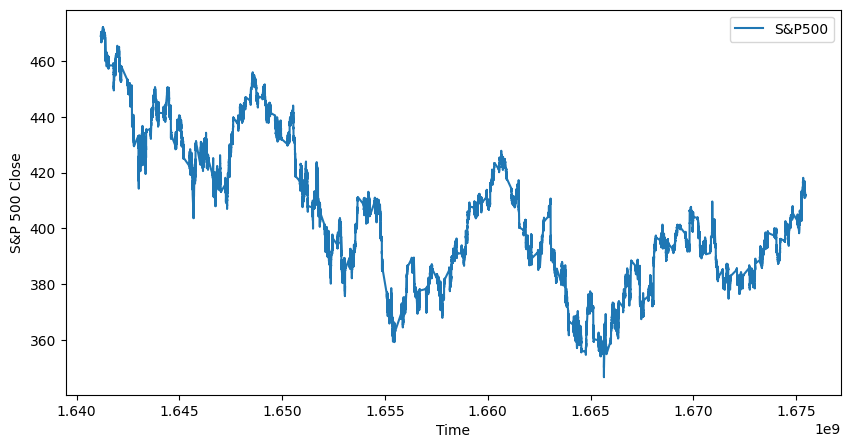

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(data.index, data["close"], label="S&P500")
plt.xlabel("Time")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.show()

In [6]:
# 4. Split to train and test 
train_ratio = 0.8
test_ratio = 0.2

# Calculate the split points based on the desired ratios
train_size = round(len(data) * train_ratio)
test_size = round(len(data) * test_ratio)
assert train_size + test_size == len(data)

train_data = data[0:train_size]
train_labels = pd.DataFrame(train_data, columns=['close'])
train_data = train_data.drop(['close'], axis=1)

test_data = data[train_size: (train_size + test_size)]
test_labels = pd.DataFrame(test_data, columns=['close'])
test_data = test_data.drop(['close'], axis=1)

In [7]:
# Check each set (train, test)
check_data_continuity(train_data)
check_data_continuity(train_labels)

check_data_continuity(test_data)
check_data_continuity(test_labels)

In [8]:
# Verify set sizes
assert len(train_data) == train_size
assert len(train_labels) == train_size
assert len(test_data) == test_size
assert len(test_labels) == test_size

# Check for overlap
assert len(set(train_data.index).intersection(set(test_data.index))) == 0


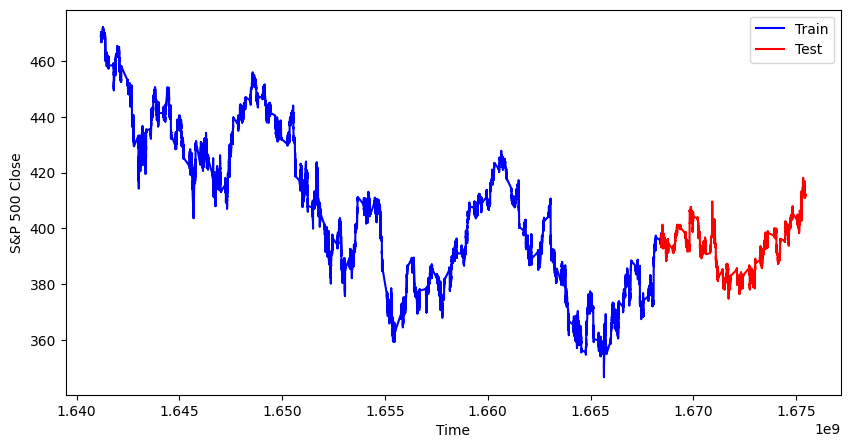

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_labels.index, train_labels["close"], label="Train", color="blue")
plt.plot(test_labels.index, test_labels["close"], label="Test", color="red")
plt.xlabel("Time")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.show()

In [10]:
# 5. Data Preprocessing
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale train features and target
X_train_scaled = scaler_X.fit_transform(train_data.values)
y_train_scaled = scaler_y.fit_transform(train_labels.values)

# Scale test features and target
X_test_scaled = scaler_X.fit_transform(test_data.values)
y_test_scaled = scaler_y.fit_transform(test_labels.values)

# Verify set sizes
assert len(X_train_scaled) == len(y_train_scaled) == train_size
assert len(X_test_scaled) == len(y_test_scaled) == test_size
assert len(X_train_scaled) + len(X_test_scaled) == train_size + test_size == len(data)

print(f"{X_train_scaled.shape=}")
print(f"{y_train_scaled.shape=}")
print(f"{X_test_scaled.shape=}")
print(f"{y_test_scaled.shape=}")


X_train_scaled.shape=(188901, 68)
y_train_scaled.shape=(188901, 1)
X_test_scaled.shape=(47225, 68)
y_test_scaled.shape=(47225, 1)


In [11]:
# 5. Prepare Data for LSTM: Create sequences
def create_sequences(X, y, lookback):  
    """Creates input sequences for LSTM."""
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        v = X[i:(i + lookback)]
        Xs.append(v)
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

lookback = 20
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, lookback)


print(f"{X_train_seq.shape=}")
print(f"{y_train_seq.shape=}")
print(f"{X_test_seq.shape=}")
print(f"{y_test_seq.shape=}")
print(f"----------------------")



X_train_seq.shape=(188881, 20, 68)
y_train_seq.shape=(188881, 1)
X_test_seq.shape=(47205, 20, 68)
y_test_seq.shape=(47205, 1)
----------------------


In [12]:

num_features = X_train_seq.shape[2] # we get the number of features here


In [13]:
# 6. Build the LSTM Model
model = keras.Sequential([
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(lookback, num_features)),
    keras.layers.LSTM(units=50, return_sequences=False),
    keras.layers.Dense(units=1)  # Output layer (predicting 'close' price)
])

# 7. Compile the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 8. Train the Model
epochs = 20
batch_size = 32
history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test_seq, y_test_seq), verbose=2)

# 9. Evaluate the Model
loss, mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Validation Loss: {loss:.8f}, Validation MAE: {mae:.8f}")




Epoch 1/20
5903/5903 - 49s - loss: 1.6539e-04 - mae: 0.0072 - val_loss: 4.9961e-04 - val_mae: 0.0163 - 49s/epoch - 8ms/step
Epoch 2/20
5903/5903 - 48s - loss: 2.9419e-05 - mae: 0.0041 - val_loss: 2.9149e-04 - val_mae: 0.0134 - 48s/epoch - 8ms/step
Epoch 3/20
5903/5903 - 49s - loss: 1.7598e-05 - mae: 0.0032 - val_loss: 9.1797e-05 - val_mae: 0.0074 - 49s/epoch - 8ms/step
Epoch 4/20
5903/5903 - 47s - loss: 1.4598e-05 - mae: 0.0029 - val_loss: 5.9619e-05 - val_mae: 0.0058 - 47s/epoch - 8ms/step
Epoch 5/20
5903/5903 - 47s - loss: 1.2975e-05 - mae: 0.0027 - val_loss: 6.5443e-05 - val_mae: 0.0062 - 47s/epoch - 8ms/step
Epoch 6/20
5903/5903 - 48s - loss: 1.1302e-05 - mae: 0.0025 - val_loss: 5.1772e-05 - val_mae: 0.0055 - 48s/epoch - 8ms/step
Epoch 7/20
5903/5903 - 48s - loss: 1.0244e-05 - mae: 0.0024 - val_loss: 4.4326e-05 - val_mae: 0.0049 - 48s/epoch - 8ms/step
Epoch 8/20
5903/5903 - 46s - loss: 1.0180e-05 - mae: 0.0024 - val_loss: 4.7258e-05 - val_mae: 0.0050 - 46s/epoch - 8ms/step
Epoch 9/

In [22]:
# 10. Optionally, make predictions and invert scaling
y_test_pred_scaled = model.predict(X_test_seq)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


1476/1476 [==============================] - 3s 2ms/step


In [23]:
import os.path

def create_directory_if_not_exists(path):
  """Creates a directory if it doesn't exist, handling existing files gracefully.
  """
  if os.path.exists(path):
    if os.path.isfile(path):
      print(f"Error: '{path}' is an existing file, not a directory.")
      return False # Indicate failure
    else: # Directory exists
      print(f"Directory '{path}' already exists.")
      return True # Indicate success - the directory exists
  else: # Path doesn't exist
    try:
      os.makedirs(path)
      print(f"Directory '{path}' created successfully.")
      return True # Success
    except OSError as e:
      print(f"Error creating directory '{path}': {e}")
      return False # Failure


In [24]:
import datetime

def get_current_datetime_formatted():
    """Returns the current date and time formatted as dd/mm/yyyy hh:mm."""
    now = datetime.datetime.now()
    formatted_datetime = now.strftime("%d_%m_%Y_%H_%M")
    return formatted_datetime


In [25]:
# Get the formatted date and time
current_datetime = get_current_datetime_formatted()
# print(current_datetime) 

cwd = os.getcwd()
# print(f"{cwd=}")

# direct to 1_min results
trained_model_folder = f"{cwd}/data/trained_models/1_min/{current_datetime}"
# print(f"{trained_model_folder=}")

trained_model_full_path = f"{trained_model_folder}/model_Loss_{loss:.8f}_MAE_{mae:.8f}.keras"

create_directory_if_not_exists(trained_model_folder)


model.save(filepath=trained_model_full_path)

print(f"Model Storage Location - \"{trained_model_full_path}\"")


Directory '/Users/ybatash/Workspace/tau.ac.il/tau-final-project/data/trained_models/1_min/26_03_2025_12_48' created successfully.
Model Storage Location - "/Users/ybatash/Workspace/tau.ac.il/tau-final-project/data/trained_models/1_min/26_03_2025_12_48/model_Loss_0.00004301_MAE_0.00470226.keras"


In [26]:
loaded_model = keras.saving.load_model(trained_model_full_path)

# Make predictions with saved model, and invert scaling
y_test_pred_scaled_loaded_model = loaded_model.predict(X_test_seq)
y_test_pred_loaded_model = scaler_y.inverse_transform(y_test_pred_scaled_loaded_model)


# Validate loaded model producing same results
import numpy.testing

# Assert close equality
numpy.testing.assert_allclose(y_test_pred, y_test_pred_loaded_model, rtol=1e-10, atol=1e-10)


1476/1476 [==============================] - 3s 2ms/step


In [27]:
# Create a result data frame with additional coulmn for predicted close price

# Recreate test data frame with close price
res_df = data[train_size: (train_size + test_size)]

# # Sanity test check if labels are aligned
# res_df["y"] = test_labels
# print(f"Check if close price equal to y -> {res_df['close'].equals(res_df['y'])}")  # Output: True

# Remove rows with out predictions - n=lookback first rows
res_df = res_df.iloc[lookback-1:]


# Add predicted_close_price to res data frame
predicted_close_price_ls = [i[0] for i  in y_test_pred.tolist()]
predicted_close_price_ls.append(-1)
res_df["predicted_close_price"] = predicted_close_price_ls

# No prediction to the last close price on t-1, Remove the last row
res_df = res_df.iloc[0:-1]


first_n_rows=236


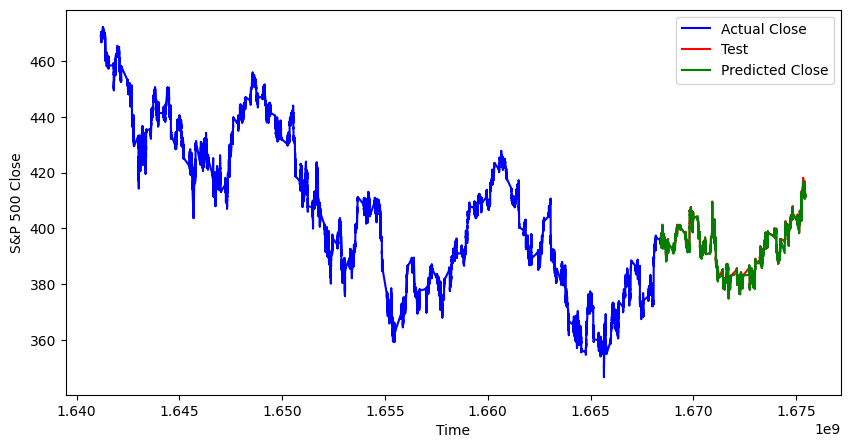

In [32]:
import matplotlib.pyplot as plt

sample_ratio = 0.005
first_n_rows = int(len(res_df)*sample_ratio)
print(f"{first_n_rows=}")

plt.figure(figsize=(10, 5))
plt.plot(train_labels.index, train_labels["close"], label="Actual Close", color="blue")
plt.plot(test_labels.index, test_labels["close"], label="Test", color="red")
plt.plot(res_df["predicted_close_price"], label='Predicted Close', color="green")
plt.xlabel("Time")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.show()

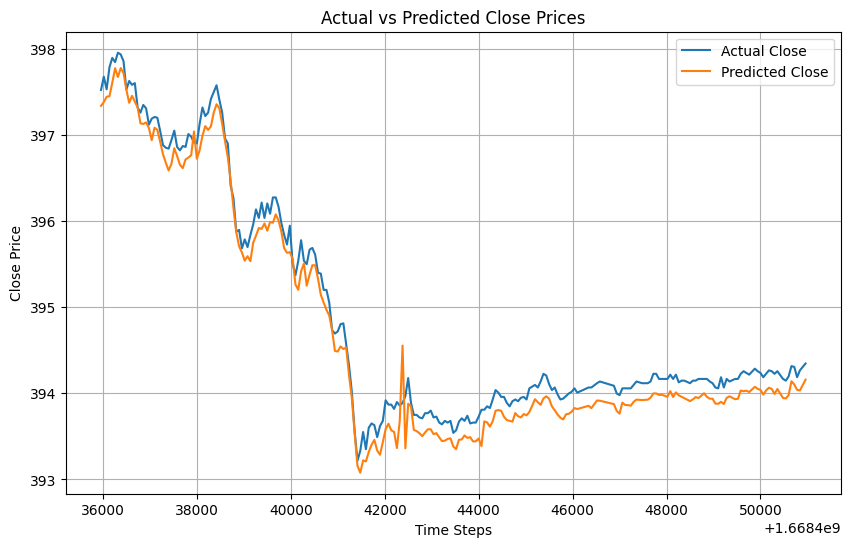

LSTM Training complete!


In [33]:
# 11. Plot the actual vs. predicted close values
plt.figure(figsize=(10, 6))
plt.plot(res_df.iloc[:first_n_rows]["close"], label='Actual Close')
plt.plot(res_df.iloc[:first_n_rows]["predicted_close_price"], label='Predicted Close')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.show()

print("LSTM Training complete!")



In [34]:
# Calculate the close_price_predicted_percentage_change
res_df['close_price_predicted_percentage_change'] = ((res_df['predicted_close_price'] - res_df['close']) / res_df['close']) * 100


# # Highest 5 values
# highest_5 = res_df.nlargest(5, 'close_price_predicted_percentage_change')
# print("Highest 5:\n", highest_5["close_price_predicted_percentage_change"])

# # Lowest 5 values
# lowest_5 = res_df.nsmallest(5, 'close_price_predicted_percentage_change')
# print("\nLowest 5:\n", lowest_5["close_price_predicted_percentage_change"])


# # Alternatively, to get the *absolute* largest changes (ignoring positive/negative):
# largest_5_absolute = res_df.iloc[res_df['close_price_predicted_percentage_change'].abs().argsort()[::-1][:5]]
# print("\nLargest 5 Absolute Changes:\n", largest_5_absolute["close_price_predicted_percentage_change"])

In [35]:
# If close_price_predicted_percentage_change >= -0.5% SELL 
# If close_price_predicted_percentage_change >= 0.5% BUY
# Else HOLD
res_df['action'] = np.where(res_df['close_price_predicted_percentage_change'] >= 0.5, 'BUY', 
                            np.where(res_df['close_price_predicted_percentage_change'] >=-0.5, 'HOLD', 
                                     'SELL'))


In [36]:

# Trading simulation
initial_capital = 10000.00
cash = initial_capital
holdings = 0.00
portfolio_value = []


for i in range(len(res_df)):
    close_price = res_df['close'].iloc[i]

    if res_df['action'].iloc[i] == 'BUY' and cash > 0:
        holdings = cash / close_price
        cash = 0

    elif res_df['action'].iloc[i] == 'SELL' and holdings > 0:
        cash = holdings * close_price
        holdings = 0

    portfolio_value.append(cash + holdings * close_price)  # Calculate portfolio value at each step

res_df['portfolio_value'] = portfolio_value

# print(res_df)

final_value = res_df['portfolio_value'].iloc[-1]
profit = final_value - initial_capital
print(f"\nFinal Portfolio Value: ${final_value:.2f}")
print(f"Profit: ${profit:.2f}")



Final Portfolio Value: $10202.29
Profit: $202.29
